# Beta Neutral Crypto Portfolio

In [174]:
# import dependencies

import pandas as pd
import numpy as np
import os
from typing import List
import cvxpy as cp


## 1. Raw Data Preparation

In [175]:
# Constants
DATA_PATH = "/Users/chriskang/Desktop/Projects/SideQuant/PxDataDownloader/data"

In [176]:
# pylint: disable=undefined-variable
# function for data loading

def list_universe():
    f_list: List[str] = os.listdir(DATA_PATH)
    symbols = [f.split('.')[0] for f in f_list if f.endswith('.parquet') and not '_' in f and 'USDT' in f]
    symbols = sorted(symbols)
    return symbols

def load_data(symbol: str, interval: str):
    target_data_path = os.path.join(DATA_PATH, f'{symbol}.parquet')
    data = pd.read_parquet(target_data_path)
    data = data[data['interval'] == interval]
    data = data.reset_index(drop=True)
    return data

def prep_many_data(symbols: List[str], interval: str):
    data = {}
    for symbol in symbols:
        df = load_data(symbol, interval)
        if len(df) < 1000:
            print(f'{symbol} has less than 1000 data points')
            continue
        data[symbol] = df 
    return data
    

In [177]:
# load universe data in the kernal
all_symbols = list_universe()
raw_data = prep_many_data(all_symbols, '4h')

AEVOUSDT has less than 1000 data points
AIUSDT has less than 1000 data points
ALTUSDT has less than 1000 data points
ANTUSDT has less than 1000 data points
AUDIOUSDT has less than 1000 data points
AXLUSDT has less than 1000 data points
BLUEBIRDUSDT has less than 1000 data points
BOMEUSDT has less than 1000 data points
BTSUSDT has less than 1000 data points
COCOSUSDT has less than 1000 data points
DYMUSDT has less than 1000 data points
ENAUSDT has less than 1000 data points
ETHFIUSDT has less than 1000 data points
FOOTBALLUSDT has less than 1000 data points
GLMUSDT has less than 1000 data points
HNTUSDT has less than 1000 data points
JUPUSDT has less than 1000 data points
LSKUSDT has less than 1000 data points
MANTAUSDT has less than 1000 data points
MAVIAUSDT has less than 1000 data points
MBLUSDT has less than 1000 data points
METISUSDT has less than 1000 data points
MYROUSDT has less than 1000 data points
OMUSDT has less than 1000 data points
ONDOUSDT has less than 1000 data points
P

# 2. Data Processing

### Symbol Selection Criteria

1. Liquidity

In [178]:
quote_volume = {}
for symbol, df in raw_data.items():
    quote_volume[symbol] = df['quote_volume'].rolling(window=42).mean().iloc[-1]  # weekly average 168/4 = 42 hrs
quote_volume = pd.Series(quote_volume)
quote_volume = quote_volume.sort_values(ascending=False)
quote_volume = quote_volume[:100]
target_symbols = quote_volume.index.tolist()
target_symbols[:5]

['BTCUSDT', 'ETHUSDT', 'SOLUSDT', '1000PEPEUSDT', 'PEOPLEUSDT']

## Compute Returns

- using close price to compute return does not resemble real market scenario
- here I used ohlc/4 (could lead to better estimate of the execution price) assuming execution over 1 time period (4h)

In [179]:
new_returns = {}
for symbol, df in raw_data.items():
    new_price = (df['close'] + df['open'] + df['high'] + df['low']) / 4
    return_df = new_price.pct_change().dropna().to_frame(name=symbol)
    return_df['timestamp'] = df['open_ts'][1:]
    return_df.set_index('timestamp', inplace=True)
    new_returns[symbol] = return_df

new_returns['BTCUSDT'].head()


,BTCUSDT
timestamp,
2019-09-25 12:00:00,-0.002820
2019-09-25 16:00:00,-0.001362
2019-09-25 20:00:00,0.013918
2019-09-26 00:00:00,-0.005566
2019-09-26 04:00:00,-0.001269


In [180]:
return_df_concat = pd.DataFrame()
for symbol, return_df in new_returns.items():
    return_df_concat = pd.merge(return_df_concat, return_df, how='outer', left_index=True, right_index=True)
return_df_concat.dropna(inplace=True)

return_df_concat.head()

,1000BONKUSDT,1000FLOKIUSDT,1000LUNCUSDT,1000PEPEUSDT,1000RATSUSDT,1000SATSUSDT,1000SHIBUSDT,1000XECUSDT,1INCHUSDT,AAVEUSDT,...,XRPUSDT,XTZUSDT,XVGUSDT,XVSUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-27 20:00:00,-0.005224,0.009462,0.003762,-0.003986,0.012181,0.017930,-0.000369,0.074169,-0.003499,0.008036,...,0.000628,0.010825,0.001140,-0.006656,-0.000923,-0.033997,-0.000236,-0.015040,-0.004038,0.001731
2023-12-28 00:00:00,-0.027055,0.009508,0.006874,0.013249,0.006131,0.009937,0.012519,0.043504,0.003177,0.067833,...,0.004983,-0.011156,0.004302,0.015489,0.012455,0.003682,0.009032,0.004404,0.004976,0.036643
2023-12-28 04:00:00,-0.048755,0.009819,0.023671,-0.013331,-0.016166,-0.005855,-0.006228,0.005610,-0.006889,0.046264,...,0.003553,-0.017374,-0.003969,-0.000803,-0.005415,-0.007128,0.009652,-0.003349,-0.010819,0.024610
2023-12-28 08:00:00,-0.019330,-0.006350,-0.002479,-0.021190,-0.042084,-0.013381,-0.004706,-0.011220,0.000168,-0.026539,...,-0.001790,-0.011022,0.016825,-0.026180,0.002781,-0.008288,0.005474,0.020073,-0.011679,-0.010350
2023-12-28 12:00:00,-0.001419,-0.036147,-0.030930,-0.026373,-0.041171,-0.035314,-0.014115,-0.005385,-0.026177,-0.034222,...,-0.007990,-0.011377,-0.015053,-0.012557,-0.012688,-0.036942,-0.012728,-0.013393,-0.019600,-0.025914


In [181]:
return_df = return_df_concat
return_df.head()

,1000BONKUSDT,1000FLOKIUSDT,1000LUNCUSDT,1000PEPEUSDT,1000RATSUSDT,1000SATSUSDT,1000SHIBUSDT,1000XECUSDT,1INCHUSDT,AAVEUSDT,...,XRPUSDT,XTZUSDT,XVGUSDT,XVSUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-27 20:00:00,-0.005224,0.009462,0.003762,-0.003986,0.012181,0.017930,-0.000369,0.074169,-0.003499,0.008036,...,0.000628,0.010825,0.001140,-0.006656,-0.000923,-0.033997,-0.000236,-0.015040,-0.004038,0.001731
2023-12-28 00:00:00,-0.027055,0.009508,0.006874,0.013249,0.006131,0.009937,0.012519,0.043504,0.003177,0.067833,...,0.004983,-0.011156,0.004302,0.015489,0.012455,0.003682,0.009032,0.004404,0.004976,0.036643
2023-12-28 04:00:00,-0.048755,0.009819,0.023671,-0.013331,-0.016166,-0.005855,-0.006228,0.005610,-0.006889,0.046264,...,0.003553,-0.017374,-0.003969,-0.000803,-0.005415,-0.007128,0.009652,-0.003349,-0.010819,0.024610
2023-12-28 08:00:00,-0.019330,-0.006350,-0.002479,-0.021190,-0.042084,-0.013381,-0.004706,-0.011220,0.000168,-0.026539,...,-0.001790,-0.011022,0.016825,-0.026180,0.002781,-0.008288,0.005474,0.020073,-0.011679,-0.010350
2023-12-28 12:00:00,-0.001419,-0.036147,-0.030930,-0.026373,-0.041171,-0.035314,-0.014115,-0.005385,-0.026177,-0.034222,...,-0.007990,-0.011377,-0.015053,-0.012557,-0.012688,-0.036942,-0.012728,-0.013393,-0.019600,-0.025914


Prepare train and test return data

In [182]:
train_return_df = return_df.reset_index().loc[len(return_df)-2000:len(return_df)-1000].iloc[:-1].set_index('timestamp')
test_return_df = return_df.reset_index().loc[len(return_df)-1000:].set_index('timestamp')
full_return_df = pd.concat([train_return_df, test_return_df])

print(f"train_return_df {train_return_df.shape}")
print(train_return_df['BTCUSDT'].tail())
print(f"test_return_df {test_return_df.shape}")
print(test_return_df['BTCUSDT'].head())

train_return_df (24, 243)
timestamp
2023-12-31 00:00:00   -0.001443
2023-12-31 04:00:00    0.004926
2023-12-31 08:00:00    0.004623
2023-12-31 12:00:00   -0.002074
2023-12-31 16:00:00    0.001500
Name: BTCUSDT, dtype: float64
test_return_df (1000, 243)
timestamp
2023-12-31 20:00:00   -0.003522
2024-01-01 00:00:00    0.000025
2024-01-01 04:00:00   -0.000855
2024-01-01 08:00:00    0.005325
2024-01-01 12:00:00    0.002953
Name: BTCUSDT, dtype: float64


# 3. Optimization

In [183]:
# return data to use for optimization, last 1000 data points
Sigma = train_return_df.cov()
Sigma.head()

,1000BONKUSDT,1000FLOKIUSDT,1000LUNCUSDT,1000PEPEUSDT,1000RATSUSDT,1000SATSUSDT,1000SHIBUSDT,1000XECUSDT,1INCHUSDT,AAVEUSDT,...,XRPUSDT,XTZUSDT,XVGUSDT,XVSUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
1000BONKUSDT,0.000659,0.000032,-0.000060,0.000124,0.000171,0.000151,0.000032,-0.000122,0.000086,-0.000215,...,0.000008,0.000077,0.000040,0.000045,0.000025,0.000129,-0.000102,-0.000146,0.000047,-0.000022
1000FLOKIUSDT,0.000032,0.000138,0.000113,0.000113,0.000146,0.000129,0.000050,0.000076,0.000095,0.000105,...,0.000032,0.000044,0.000118,0.000060,0.000048,0.000097,0.000031,0.000005,0.000065,0.000116
1000LUNCUSDT,-0.000060,0.000113,0.000159,0.000082,0.000099,0.000085,0.000044,0.000122,0.000066,0.000165,...,0.000035,0.000041,0.000150,0.000033,0.000041,0.000058,0.000040,0.000032,0.000053,0.000106
1000PEPEUSDT,0.000124,0.000113,0.000082,0.000161,0.000144,0.000137,0.000063,0.000091,0.000103,0.000085,...,0.000033,0.000062,0.000119,0.000064,0.000056,0.000093,-0.000028,-0.000037,0.000083,0.000113
1000RATSUSDT,0.000171,0.000146,0.000099,0.000144,0.000477,0.000287,0.000060,0.000101,0.000086,0.000097,...,0.000034,0.000080,0.000050,0.000138,0.000061,0.000083,-0.000006,-0.000117,0.000101,0.000134


In [184]:
betas = Sigma['BTCUSDT'] / Sigma.loc['BTCUSDT', 'BTCUSDT']
betas.drop('BTCUSDT', inplace=True)
betas = betas.sort_index()
print(betas.shape)
betas.head()

(242,)


1000BONKUSDT     2.108264
1000FLOKIUSDT    1.570603
1000LUNCUSDT     1.071362
1000PEPEUSDT     1.976102
1000RATSUSDT     2.532694
Name: BTCUSDT, dtype: float64

In [185]:
train_return_df.drop('BTCUSDT', axis=1, inplace=True)  # since we are using BTC as the benchmark
final_Sigma = train_return_df.cov()
final_Sigma.shape

(242, 242)

In [186]:
n = len(train_return_df.columns)
weights = cp.Variable(n)
print(weights.shape, final_Sigma.shape)
pf_var = cp.quad_form(weights, final_Sigma.values)
objective = cp.Minimize(pf_var)

lb = -1
ub = 1
constraints = [
    weights >= lb, 
    weights <= ub, 
    weights.T @ betas == 0,
    # cp.abs(weights) <= 0.05,
    cp.sum(weights) == 1
]

prob = cp.Problem(objective, constraints)
if not prob.is_dcp():
    raise Exception("Problem is not DCP")
prob.solve(solver=cp.CLARABEL)
if prob.status != cp.OPTIMAL:
    raise Exception("Optimization problem is not solvable")

weights = weights.value
print(weights)

(242,) (242, 242)
[ 7.09485319e-03 -1.70633477e-03  5.55672363e-03 -6.57872132e-03
 -4.93959201e-03 -1.17158302e-02  8.31295180e-03 -6.60051986e-04
  1.13743073e-03  2.85098279e-03  1.65567687e-02 -2.35071620e-03
  6.12063457e-03 -4.57858562e-03  4.67606540e-03  9.43163011e-04
  5.04318375e-03 -1.73496601e-03  1.54681080e-03  2.35893739e-03
  2.55376768e-03  6.11281812e-04  5.97327611e-03 -2.23885686e-02
 -5.44332770e-03  3.72493454e-03 -4.22796963e-05 -7.77194391e-03
  2.79918354e-03 -8.50350973e-03  7.76996948e-04 -1.44351564e-02
  5.11994995e-03  1.69322700e-02 -2.30652183e-03 -6.99458044e-03
  7.63310494e-03  7.34628552e-03  9.22596973e-03  1.10555656e-02
 -9.37356213e-04  1.05028016e-02  1.66638910e-03 -2.04290987e-03
  7.27967916e-03  2.64628236e-02  9.23133304e-03  5.66978594e-03
  2.17100770e-02  1.07178513e-02  1.81950895e-03  3.96758333e-02
  3.23736869e-02  1.56773838e-04 -1.83454967e-02  4.66983320e-03
  4.60783809e-03  3.12905699e-03  5.00212498e-03  2.46417710e-03
 -5.913

In [187]:
# Normalize the weights
sum_weights = np.sum(np.abs(weights))
weights = weights / sum_weights

# Convert to Pandas to ease of read
w = pd.Series(weights, index=final_Sigma.columns)
w.round(5).head()

1000BONKUSDT     0.00355
1000FLOKIUSDT   -0.00085
1000LUNCUSDT     0.00278
1000PEPEUSDT    -0.00329
1000RATSUSDT    -0.00247
dtype: float64

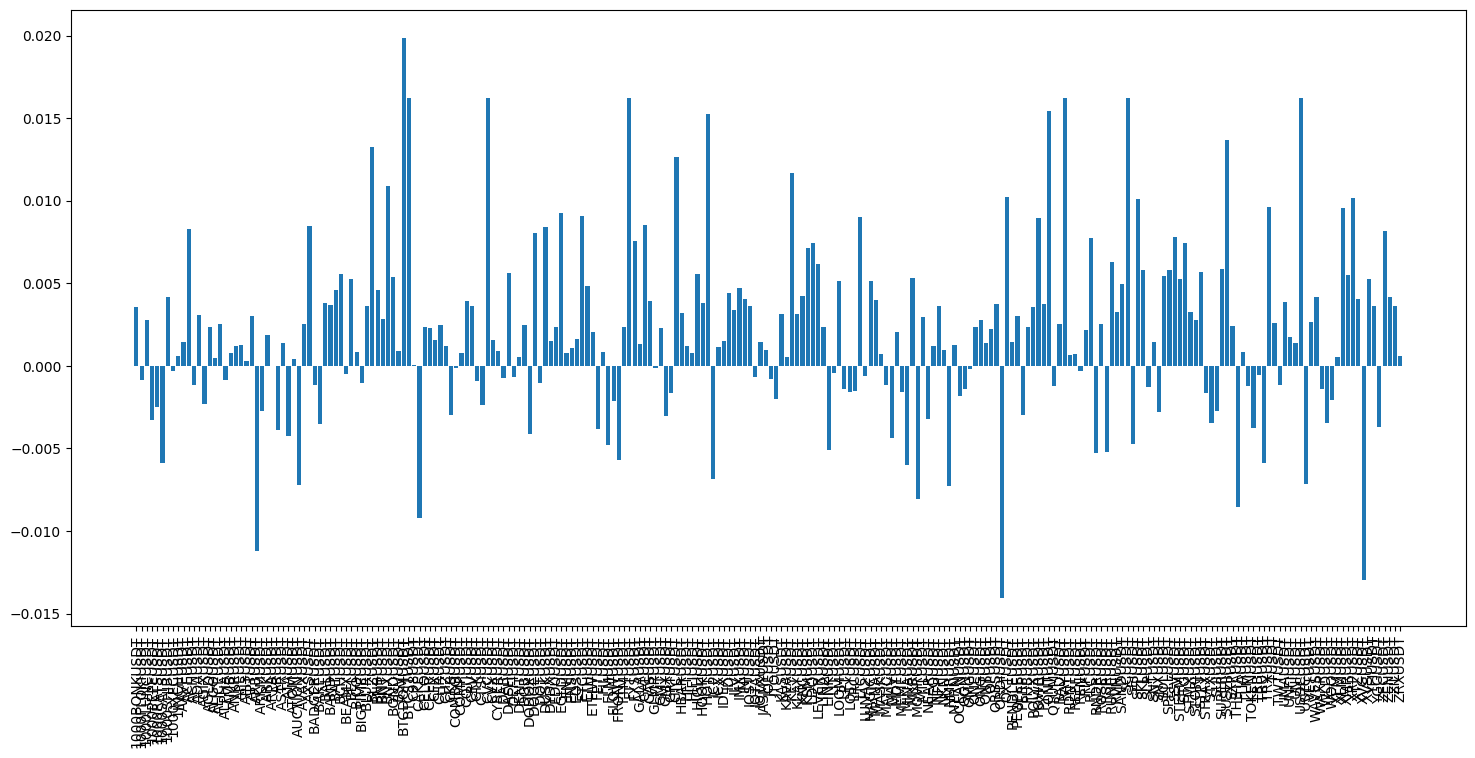

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.bar(w.index, w.values)
plt.xticks(rotation = 90);

In [189]:
weights_df = pd.DataFrame(w, columns=['weights'], index=w.index)
weights_df.head()


,weights
1000BONKUSDT,0.003553
1000FLOKIUSDT,-0.000854
1000LUNCUSDT,0.002783
1000PEPEUSDT,-0.003294
1000RATSUSDT,-0.002474


# 4. Rolling Portfolio Beta over test period (Assume rebalance every day)

In [190]:
# optimization function
def optimize_beta_neutral_portfolio(cov_matrix, mkt_betas, lower_bound: float, upper_bound: float) -> pd.DataFrame:
    n = cov_matrix.shape[1]
    weights = cp.Variable(n)
    pf_var = cp.quad_form(weights, cov_matrix.values)
    objective = cp.Minimize(pf_var)

    constraints = [
        weights >= lower_bound, 
        weights <= upper_bound, 
        weights.T @ mkt_betas == 0,
        cp.abs(weights) <= 0.2,
        cp.sum(weights) == 1
    ]

    prob = cp.Problem(objective, constraints)
    if not prob.is_dcp():
        raise Exception("Problem is not DCP")

    prob.solve(solver=cp.CLARABEL)
    if prob.status != cp.OPTIMAL:
        raise Exception("Optimization problem is not solvable")

    weights = weights.value

    sum_weights = np.sum(np.abs(weights))
    weights = weights / sum_weights

    w = pd.Series(weights, index=cov_matrix.columns).to_frame(name='weights')

    return w

In [191]:
# rolling covariance matrix starting from the test data
rolling_cov = full_return_df.rolling(window=42).cov().dropna()
rolling_cov.head()

1000BONKUSDT  1000FLOKIUSDT  1000LUNCUSDT  \
timestamp                                                                      
2024-01-03 16:00:00 1000BONKUSDT       0.000850       0.000326      0.000387   
                    1000FLOKIUSDT      0.000326       0.000335      0.000395   
                    1000LUNCUSDT       0.000387       0.000395      0.000549   
                    1000PEPEUSDT       0.000458       0.000347      0.000435   
                    1000RATSUSDT       0.000554       0.000434      0.000532   

                                   1000PEPEUSDT  1000RATSUSDT  1000SATSUSDT  \
timestamp                                                                     
2024-01-03 16:00:00 1000BONKUSDT       0.000458      0.000554      0.000418   
                    1000FLOKIUSDT      0.000347      0.000434      0.000321   
                    1000LUNCUSDT       0.000435      0.000532      0.000375   
                    1000PEPEUSDT       0.000455      0.000457      0.000348   
                    1000RATSUSDT       0.000457      0.000939      0.000598   

                                   1000SHIBUSDT  1000XECUSDT  1INCHUSDT  \
timestamp                                                                 
2024-01-03 16:00:00 1000BONKUSDT       0.000267     0.000168   0.000166   
                    1000FLOKIUSDT      0.000224     0.000229   0.000185   
                    1000LUNCUSDT       0.000295     0.000332   0.000271   
                    1000PEPEUSDT       0.000269     0.000269   0.000224   
                    1000RATSUSDT       0.000326     0.000326   0.000178   

                                   AAVEUSDT  ...   XRPUSDT   XTZUSDT  \
timestamp                                    ...                       
2024-01-03 16:00:00 1000BONKUSDT   0.000196  ...  0.000246  0.000330   
                    1000FLOKIUSDT  0.000277  ...  0.000206  0.000253   
                    1000LUNCUSDT   0.000398  ...  0.000289  0.000344   
                    1000PEPEUSDT   0.000316  ...  0.000252  0.000323   
                    1000RATSUSDT   0.000369  ...  0.000298  0.000349   

                                    XVGUSDT   XVSUSDT   YFIUSDT   YGGUSDT  \
timestamp                                                                   
2024-01-03 16:00:00 1000BONKUSDT   0.000355  0.000063  0.000217  0.000148   
                    1000FLOKIUSDT  0.000326  0.000051  0.000192  0.000069   
                    1000LUNCUSDT   0.000440  0.000052  0.000247  0.000094   
                    1000PEPEUSDT   0.000350  0.000089  0.000220  0.000157   
                    1000RATSUSDT   0.000420  0.000094  0.000272  0.000065   

                                    ZECUSDT   ZENUSDT   ZILUSDT   ZRXUSDT  
timestamp                                                                  
2024-01-03 16:00:00 1000BONKUSDT   0.000246  0.000258  0.000307  0.000280  
                    1000FLOKIUSDT  0.000248  0.000272  0.000274  0.000302  
                    1000LUNCUSDT   0.000344  0.000388  0.000349  0.000383  
                    1000PEPEUSDT   0.000264  0.000302  0.000322  0.000336  
                    1000RATSUSDT   0.000350  0.000358  0.000376  0.000434  

[5 rows x 243 columns]

In [192]:
# rolling optimization
dates = set(rolling_cov.index.get_level_values(0))
weights = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = test_return_df.columns)
betas = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = test_return_df.columns)

for dt in dates:
    full_cov = rolling_cov.loc[dt]
    final_cov = full_cov.drop('BTCUSDT').drop('BTCUSDT', axis=1)
    final_beta = full_cov['BTCUSDT'].drop('BTCUSDT') / full_cov.loc['BTCUSDT', 'BTCUSDT']
    
    weight_result = optimize_beta_neutral_portfolio(final_cov, final_beta, -1, 1)
    weights.loc[dt, :] = weight_result['weights']
    betas.loc[dt, :] = final_beta

In [193]:
weights.drop('BTCUSDT', axis=1, inplace=True)
betas.drop('BTCUSDT', axis=1, inplace=True)

In [194]:
portfolio_beta = (weights.shift(1) * betas).dropna().sum(axis=1)
portfolio_beta.head()

2024-01-03 20:00:00      0.0005
2024-01-04 00:00:00    0.004723
2024-01-04 04:00:00    0.000417
2024-01-04 08:00:00    0.000405
2024-01-04 12:00:00    0.005834
dtype: object

Text(0.5, 1.0, 'Mkt Neutral Portfolio Rolling Beta to Market')

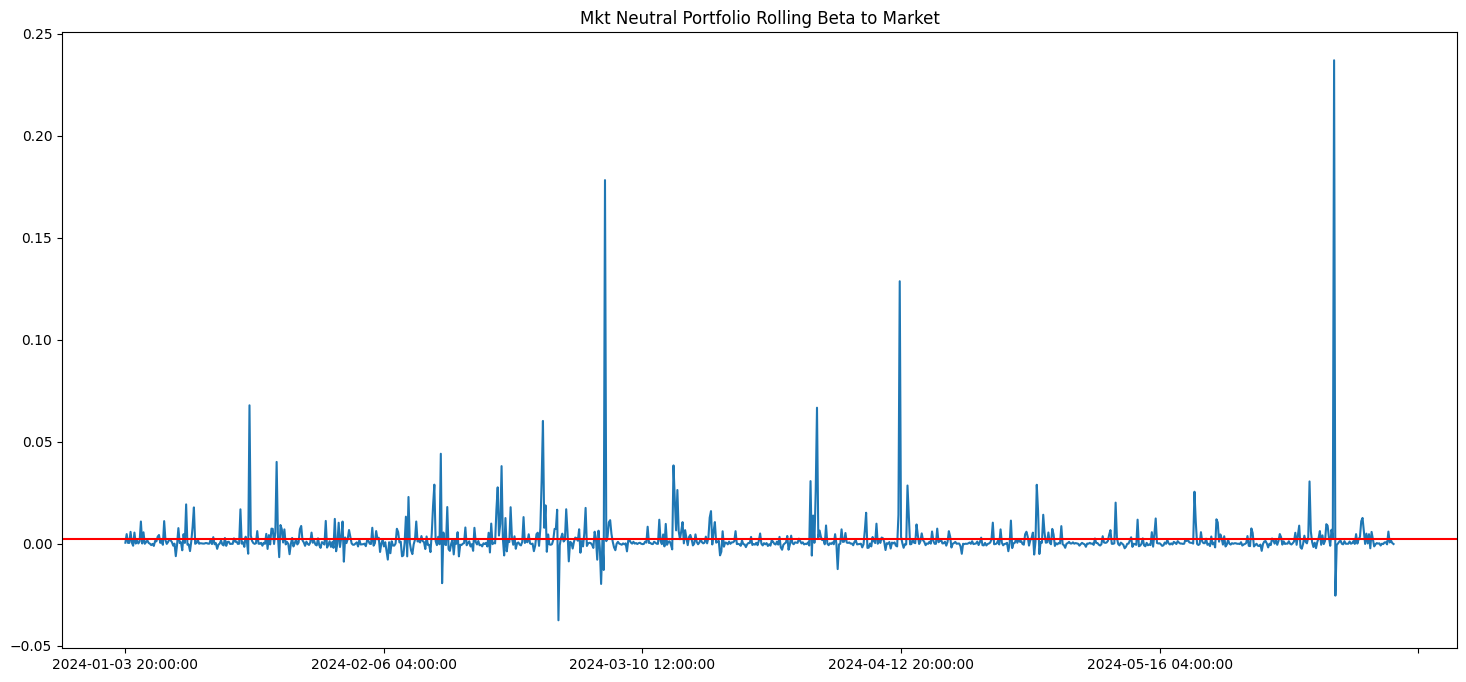

In [195]:
portfolio_beta.plot(figsize=(18, 8))
plt.axhline(portfolio_beta.mean(), color="red")
plt.title("Mkt Neutral Portfolio Rolling Beta to Market")

Text(0.5, 1.0, 'Backtest of Market Neutral Portfolio Return')

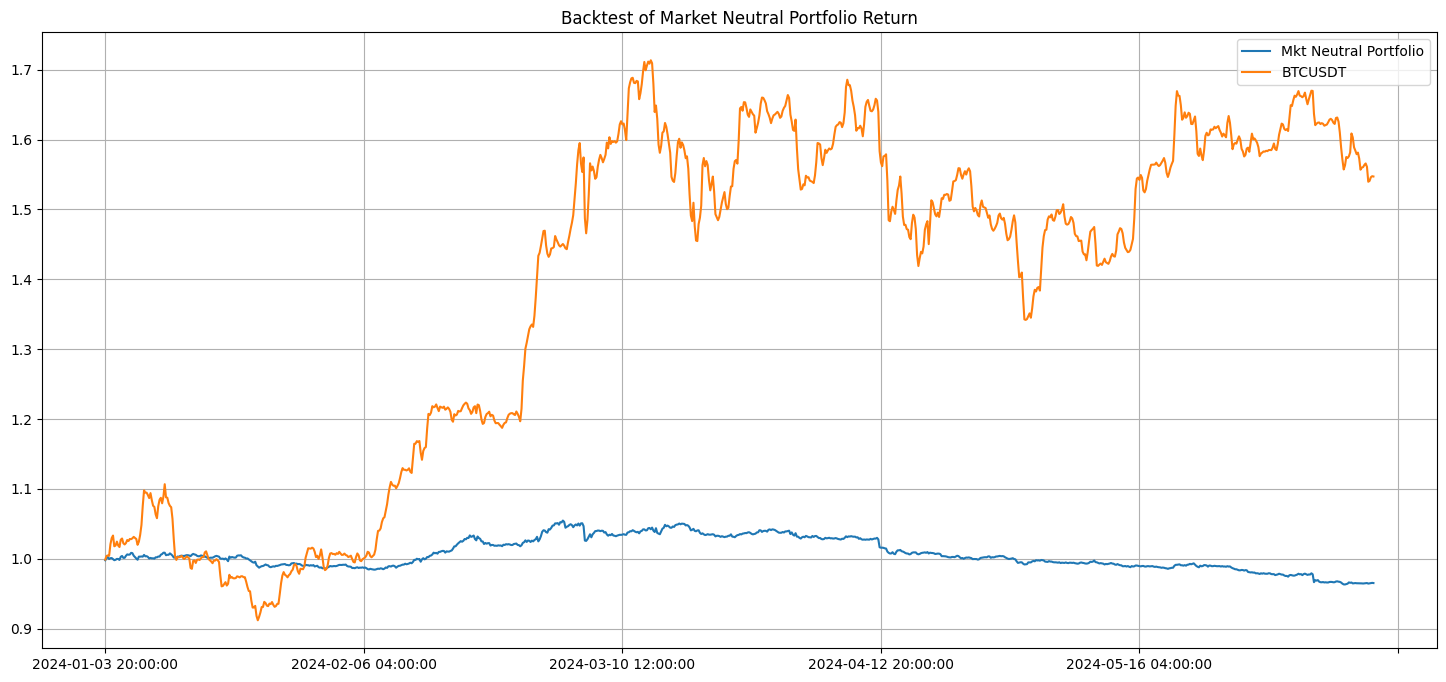

In [198]:
# process the order of the weights and test_return_df are the same
weights = weights.T.sort_index().T
# test_return_df = test_return_df.T.sort_index().T.drop('BTCUSDT', axis=1)
test_return_df = test_return_df.T.sort_index().T
# test_return_df = test_return_df.T.sort_index().T



portfolio_ret = (weights.shift(1) * test_return_df).dropna().sum(axis=1)
(1 + portfolio_ret).cumprod().plot(figsize=(18, 8), label="Mkt Neutral Portfolio")
(1 + full_return_df.loc[portfolio_ret.index].BTCUSDT).cumprod().plot()
plt.grid()
plt.legend()
plt.title("Backtest of Market Neutral Portfolio Return")